In [13]:
pip install torch

Defaulting to user installation because normal site-packages is not writeable
  Using cached torch-2.8.0-cp310-cp310-win_amd64.whl (241.4 MB)
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.23.0+cu126 requires torch==2.8.0+cu126, but you have torch 2.8.0 which is incompatible.

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

     ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
     -------------------------------------- 294.9/294.9 kB 6.1 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd

In [2]:
import re
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

In [11]:
import torch

In [3]:
df = pd.read_csv("master_final.csv", index_col = 0)

In [4]:
def string_parser(s: str):

    cleaned_s = s.strip().replace("]",'').replace("[",'')

    return [float(item) for item in re.split(r'\s+', cleaned_s) if item]

In [5]:
X = df["contextual_meta_embedding"].apply(string_parser).to_list()
y_exec = df["exec_embedding"].apply(string_parser).to_list()
y_style = df["style_embedding"].apply(string_parser).to_list()
y_content = df["content_embedding"].apply(string_parser).to_list()

In [7]:
(X_train_val, X_test, 
 y_content_train_val, y_content_test, 
 y_exec_train_val, y_exec_test, 
 y_style_train_val, y_style_test) = train_test_split(
    X, y_content, y_exec, y_style, 
    test_size=0.1, 
    random_state=42
)

In [8]:
(X_train, X_val,
 y_content_train, y_content_val,
 y_exec_train, y_exec_val,
 y_style_train, y_style_val) = train_test_split(
    X_train_val, y_content_train_val, y_exec_train_val, y_style_train_val,
    test_size=1/9, 
    random_state=42
)

In [9]:
class PromptDataset(Dataset):

    def __init__(self, context_embeds, content_labels, exec_labels, style_labels):
        self.context_embeds = torch.tensor(context_embeds, dtype = torch.float32)
        self.content_labels = torch.tensor(content_labels, dtype = torch.float32)
        self.exec_labels = torch.tensor(exec_labels, dtype=torch.float32)
        self.style_labels = torch.tensor(style_labels, dtype=torch.float32)

    def __len__(self):
        return len(self.context_embeds)

    def __getitem__(self, idx):
        return (self.context_embeds[idx], self.content_labels[idx], self.exec_labels[idx], self.style_labels[idx])

In [12]:
train_dataset = PromptDataset(X_train, y_content_train, y_exec_train, y_style_train)
val_dataset = PromptDataset(X_val, y_content_val, y_exec_val, y_style_val)
test_dataset = PromptDataset(X_test, y_content_test, y_exec_test, y_style_test)

In [13]:
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE)

In [14]:
class PromptDecomposerMLP(nn.Module):
    def __init__(self, input_size, shared_hidden_size, output_embedding_size, dropout_rate = 0.3):
        super(PromptDecomposerMLP, self).__init__()
        self.shared_trunk = nn.Sequential(
            nn.Linear(input_size, shared_hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(shared_hidden_size, shared_hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        self.content_head = nn.Linear(shared_hidden_size // 2, output_embedding_size)
        self.execution_head = nn.Linear(shared_hidden_size // 2, output_embedding_size)
        self.style_head = nn.Linear(shared_hidden_size // 2, output_embedding_size)

    def forward(self, x):
        shared_features = self.shared_trunk(x)
        content_out = self.content_head(shared_features)
        exec_out = self.execution_head(shared_features)
        style_out = self.style_head(shared_features)
        return content_out, exec_out, style_out

In [15]:
INPUT_EMBEDDING_SIZE = 768
OUTPUT_EMBEDDING_SIZE = 768
SHARED_HIDDEN_SIZE = 1024
LEARNING_RATE = 1e-4
NUM_EPOCHS = 50

device = "cuda" if torch.cuda.is_available() else "cpu"
model = PromptDecomposerMLP(INPUT_EMBEDDING_SIZE, SHARED_HIDDEN_SIZE, OUTPUT_EMBEDDING_SIZE).to(device)
loss_fn = nn.CosineEmbeddingLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE)

Epoch 1/50: 100%|██████████| 216/216 [00:02<00:00, 74.31it/s, loss=1.76]


Epoch 1 - Validation Loss: 1.5749
  -> New best model saved with validation loss: 1.5749


Epoch 2/50: 100%|██████████| 216/216 [00:02<00:00, 75.93it/s, loss=1.61]


Epoch 2 - Validation Loss: 1.5557
  -> New best model saved with validation loss: 1.5557


Epoch 3/50: 100%|██████████| 216/216 [00:02<00:00, 77.10it/s, loss=1.59]


Epoch 3 - Validation Loss: 1.5030
  -> New best model saved with validation loss: 1.5030


Epoch 4/50: 100%|██████████| 216/216 [00:02<00:00, 76.75it/s, loss=1.51]


Epoch 4 - Validation Loss: 1.4784
  -> New best model saved with validation loss: 1.4784


Epoch 5/50: 100%|██████████| 216/216 [00:02<00:00, 78.09it/s, loss=1.52]


Epoch 5 - Validation Loss: 1.4634
  -> New best model saved with validation loss: 1.4634


Epoch 6/50: 100%|██████████| 216/216 [00:02<00:00, 75.12it/s, loss=1.5] 


Epoch 6 - Validation Loss: 1.4547
  -> New best model saved with validation loss: 1.4547


Epoch 7/50: 100%|██████████| 216/216 [00:02<00:00, 75.76it/s, loss=1.49]


Epoch 7 - Validation Loss: 1.4465
  -> New best model saved with validation loss: 1.4465


Epoch 8/50: 100%|██████████| 216/216 [00:02<00:00, 76.79it/s, loss=1.45]


Epoch 8 - Validation Loss: 1.4410
  -> New best model saved with validation loss: 1.4410


Epoch 9/50: 100%|██████████| 216/216 [00:02<00:00, 76.21it/s, loss=1.42]


Epoch 9 - Validation Loss: 1.4371
  -> New best model saved with validation loss: 1.4371


Epoch 10/50: 100%|██████████| 216/216 [00:02<00:00, 76.75it/s, loss=1.47]


Epoch 10 - Validation Loss: 1.4378


Epoch 11/50: 100%|██████████| 216/216 [00:02<00:00, 76.81it/s, loss=1.43]


Epoch 11 - Validation Loss: 1.4314
  -> New best model saved with validation loss: 1.4314


Epoch 12/50: 100%|██████████| 216/216 [00:02<00:00, 75.95it/s, loss=1.39]


Epoch 12 - Validation Loss: 1.4306
  -> New best model saved with validation loss: 1.4306


Epoch 13/50: 100%|██████████| 216/216 [00:02<00:00, 74.34it/s, loss=1.41]


Epoch 13 - Validation Loss: 1.4297
  -> New best model saved with validation loss: 1.4297


Epoch 14/50: 100%|██████████| 216/216 [00:02<00:00, 75.70it/s, loss=1.4] 


Epoch 14 - Validation Loss: 1.4302


Epoch 15/50: 100%|██████████| 216/216 [00:02<00:00, 76.61it/s, loss=1.38]


Epoch 15 - Validation Loss: 1.4270
  -> New best model saved with validation loss: 1.4270


Epoch 16/50: 100%|██████████| 216/216 [00:02<00:00, 76.02it/s, loss=1.36]


Epoch 16 - Validation Loss: 1.4390


Epoch 17/50: 100%|██████████| 216/216 [00:02<00:00, 76.21it/s, loss=1.33]


Epoch 17 - Validation Loss: 1.4302


Epoch 18/50: 100%|██████████| 216/216 [00:02<00:00, 76.48it/s, loss=1.32]


Epoch 18 - Validation Loss: 1.4394


Epoch 19/50: 100%|██████████| 216/216 [00:02<00:00, 75.53it/s, loss=1.32]


Epoch 19 - Validation Loss: 1.4413


Epoch 20/50: 100%|██████████| 216/216 [00:02<00:00, 75.61it/s, loss=1.32]


Epoch 20 - Validation Loss: 1.4450


Epoch 21/50: 100%|██████████| 216/216 [00:02<00:00, 74.57it/s, loss=1.31]


Epoch 21 - Validation Loss: 1.4450


Epoch 22/50: 100%|██████████| 216/216 [00:02<00:00, 77.57it/s, loss=1.3] 


Epoch 22 - Validation Loss: 1.4416


Epoch 23/50: 100%|██████████| 216/216 [00:02<00:00, 75.29it/s, loss=1.28]


Epoch 23 - Validation Loss: 1.4468


Epoch 24/50: 100%|██████████| 216/216 [00:02<00:00, 77.57it/s, loss=1.27]


Epoch 24 - Validation Loss: 1.4497


Epoch 25/50: 100%|██████████| 216/216 [00:02<00:00, 76.26it/s, loss=1.25]


Epoch 25 - Validation Loss: 1.4442


Epoch 26/50: 100%|██████████| 216/216 [00:02<00:00, 75.39it/s, loss=1.25]


Epoch 26 - Validation Loss: 1.4537


Epoch 27/50: 100%|██████████| 216/216 [00:02<00:00, 76.21it/s, loss=1.21]


Epoch 27 - Validation Loss: 1.4597


Epoch 28/50: 100%|██████████| 216/216 [00:02<00:00, 76.49it/s, loss=1.22]


Epoch 28 - Validation Loss: 1.4562


Epoch 29/50: 100%|██████████| 216/216 [00:02<00:00, 75.55it/s, loss=1.21]


Epoch 29 - Validation Loss: 1.4599


Epoch 30/50: 100%|██████████| 216/216 [00:02<00:00, 76.70it/s, loss=1.18]


Epoch 30 - Validation Loss: 1.4662


Epoch 31/50: 100%|██████████| 216/216 [00:02<00:00, 76.59it/s, loss=1.17]


Epoch 31 - Validation Loss: 1.4581


Epoch 32/50: 100%|██████████| 216/216 [00:02<00:00, 75.66it/s, loss=1.2] 


Epoch 32 - Validation Loss: 1.4623


Epoch 33/50: 100%|██████████| 216/216 [00:02<00:00, 76.44it/s, loss=1.16]


Epoch 33 - Validation Loss: 1.4566


Epoch 34/50: 100%|██████████| 216/216 [00:02<00:00, 75.85it/s, loss=1.18]


Epoch 34 - Validation Loss: 1.4633


Epoch 35/50: 100%|██████████| 216/216 [00:02<00:00, 77.18it/s, loss=1.15]


Epoch 35 - Validation Loss: 1.4735


Epoch 36/50: 100%|██████████| 216/216 [00:02<00:00, 75.71it/s, loss=1.16]


Epoch 36 - Validation Loss: 1.4782


Epoch 37/50: 100%|██████████| 216/216 [00:02<00:00, 76.56it/s, loss=1.14]


Epoch 37 - Validation Loss: 1.4748


Epoch 38/50: 100%|██████████| 216/216 [00:02<00:00, 76.09it/s, loss=1.12]


Epoch 38 - Validation Loss: 1.4717


Epoch 39/50: 100%|██████████| 216/216 [00:02<00:00, 76.29it/s, loss=1.12]


Epoch 39 - Validation Loss: 1.4786


Epoch 40/50: 100%|██████████| 216/216 [00:02<00:00, 76.82it/s, loss=1.12]


Epoch 40 - Validation Loss: 1.4860


Epoch 41/50: 100%|██████████| 216/216 [00:02<00:00, 77.77it/s, loss=1.09]


Epoch 41 - Validation Loss: 1.4877


Epoch 42/50: 100%|██████████| 216/216 [00:02<00:00, 78.47it/s, loss=1.11]


Epoch 42 - Validation Loss: 1.4803


Epoch 43/50: 100%|██████████| 216/216 [00:02<00:00, 77.83it/s, loss=1.11]


Epoch 43 - Validation Loss: 1.4927


Epoch 44/50: 100%|██████████| 216/216 [00:02<00:00, 76.84it/s, loss=1.09]


Epoch 44 - Validation Loss: 1.4925


Epoch 45/50: 100%|██████████| 216/216 [00:02<00:00, 75.61it/s, loss=1.1] 


Epoch 45 - Validation Loss: 1.4983


Epoch 46/50: 100%|██████████| 216/216 [00:02<00:00, 75.97it/s, loss=1.06]


Epoch 46 - Validation Loss: 1.4981


Epoch 47/50: 100%|██████████| 216/216 [00:02<00:00, 74.69it/s, loss=1.07]


Epoch 47 - Validation Loss: 1.5008


Epoch 48/50: 100%|██████████| 216/216 [00:02<00:00, 78.16it/s, loss=1.07]


Epoch 48 - Validation Loss: 1.5025


Epoch 49/50: 100%|██████████| 216/216 [00:02<00:00, 75.40it/s, loss=1.07]


Epoch 49 - Validation Loss: 1.5066


Epoch 50/50: 100%|██████████| 216/216 [00:02<00:00, 78.50it/s, loss=1.06]


Epoch 50 - Validation Loss: 1.5052
Training complete. Best model saved to best_model.pth


Testing on Test Set: 100%|██████████| 27/27 [00:00<00:00, 421.11it/s]



--- Final Performance on Test Set ---
Content Head   | Mean Cosine Similarity: 0.5066 | Std: 0.1345
Execution Head | Mean Cosine Similarity: 0.5187 | Std: 0.2003
Style Head     | Mean Cosine Similarity: 0.5587 | Std: 0.1876


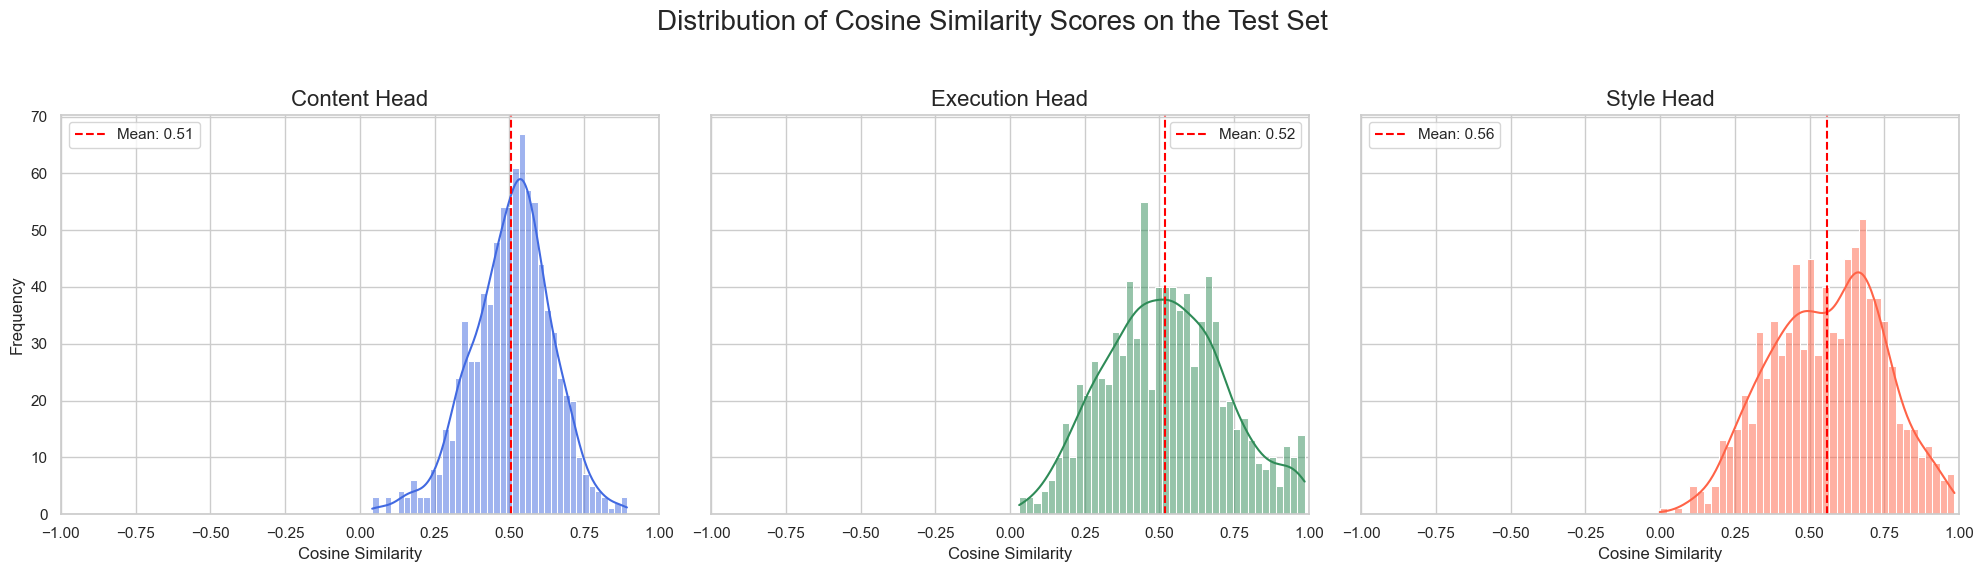

In [16]:
best_val_loss = np.inf

for epoch in range(NUM_EPOCHS):
    model.train()
    total_train_loss = 0
    train_loop = tqdm(train_loader, desc = f"Epoch {epoch + 1}/{NUM_EPOCHS}")

    for context_b, content_b, exec_b, style_b in train_loop:

        context_b, content_b, exec_b, style_b = context_b.to(device), content_b.to(device), exec_b.to(device), style_b.to(device)

        content_pred, exec_pred, style_pred = model(context_b)

        target = torch.ones(context_b.size(0)).to(device)

        loss_content = loss_fn(content_pred, content_b, target)
        loss_exec = loss_fn(exec_pred, exec_b, target)
        loss_style = loss_fn(style_pred, style_b, target)

        total_batch_loss = loss_content + loss_exec + loss_style
        
        optimizer.zero_grad()
        total_batch_loss.backward()
        optimizer.step()

        total_train_loss += total_batch_loss.item()
        train_loop.set_postfix(loss = total_train_loss / (train_loop.n + 1))

    model.eval()
    total_val_loss = 0
    with torch.no_grad():

        for context_b, content_b, style_b, exec_b in val_loader:
            context_b, content_b, style_b, exec_b = context_b.to(device), content_b.to(device), style_b.to(device), exec_b.to(device)

            content_pred, style_pred, exec_pred = model(context_b)

            target = torch.ones(context_b.size(0)).to(device)
            loss_content = loss_fn(content_pred, content_b, target)
            loss_style = loss_fn(style_pred, style_b, target)
            loss_exec = loss_fn(exec_pred, exec_b, target)

            total_batch_loss = loss_content + loss_style + loss_exec
            total_val_loss += total_batch_loss.item()
    
    avg_val_loss = total_val_loss / len(val_loader)
    print(f"Epoch {epoch + 1} - Validation Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_model.pth")
        print(f"  -> New best model saved with validation loss: {best_val_loss:.4f}")

print("Training complete. Best model saved to best_model.pth")


model.load_state_dict(torch.load("best_model.pth"))
model.to(device)
model.eval()

content_similarities = []
exec_similarities = []
style_similarities = []

with torch.no_grad():

    for context_b, content_b, exec_b, style_b in tqdm(test_loader, desc="Testing on Test Set"):

        context_b, content_b, exec_b, style_b = context_b.to(device), content_b.to(device), exec_b.to(device), style_b.to(device)

        content_pred, exec_pred, style_pred = model(context_b)

        content_sim = F.cosine_similarity(content_pred, content_b, dim=1)
        exec_sim = F.cosine_similarity(exec_pred, exec_b, dim=1)
        style_sim = F.cosine_similarity(style_pred, style_b, dim=1)

        content_similarities.extend(content_sim.cpu().numpy())
        exec_similarities.extend(exec_sim.cpu().numpy())
        style_similarities.extend(style_sim.cpu().numpy())

print("\n--- Final Performance on Test Set ---")
print(f"Content Head   | Mean Cosine Similarity: {np.mean(content_similarities):.4f} | Std: {np.std(content_similarities):.4f}")
print(f"Execution Head | Mean Cosine Similarity: {np.mean(exec_similarities):.4f} | Std: {np.std(exec_similarities):.4f}")
print(f"Style Head     | Mean Cosine Similarity: {np.mean(style_similarities):.4f} | Std: {np.std(style_similarities):.4f}")

sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
fig.suptitle('Distribution of Cosine Similarity Scores on the Test Set', fontsize=20)

sns.histplot(ax=axes[0], data=content_similarities, kde=True, bins=40, color='royalblue')
axes[0].set_title('Content Head', fontsize=16)
axes[0].set_xlabel('Cosine Similarity', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_xlim(-1, 1)
axes[0].axvline(np.mean(content_similarities), color='red', linestyle='--', label=f'Mean: {np.mean(content_similarities):.2f}')
axes[0].legend()

sns.histplot(ax=axes[1], data=exec_similarities, kde=True, bins=40, color='seagreen')
axes[1].set_title('Execution Head', fontsize=16)
axes[1].set_xlabel('Cosine Similarity', fontsize=12)
axes[1].set_xlim(-1, 1)
axes[1].axvline(np.mean(exec_similarities), color='red', linestyle='--', label=f'Mean: {np.mean(exec_similarities):.2f}')
axes[1].legend()

sns.histplot(ax=axes[2], data=style_similarities, kde=True, bins=40, color='tomato')
axes[2].set_title('Style Head', fontsize=16)
axes[2].set_xlabel('Cosine Similarity', fontsize=12)
axes[2].set_xlim(-1, 1)
axes[2].axvline(np.mean(style_similarities), color='red', linestyle='--', label=f'Mean: {np.mean(style_similarities):.2f}')
axes[2].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Calculating Baseline Similarities: 100%|██████████| 27/27 [00:00<00:00, 558.15it/s]



--- Baseline Performance on Test Set (Input vs. Target) ---
Content   | Mean Cosine Similarity: 0.3300 | Std: 0.1259
Execution | Mean Cosine Similarity: 0.2017 | Std: 0.0942
Style     | Mean Cosine Similarity: 0.2296 | Std: 0.1042


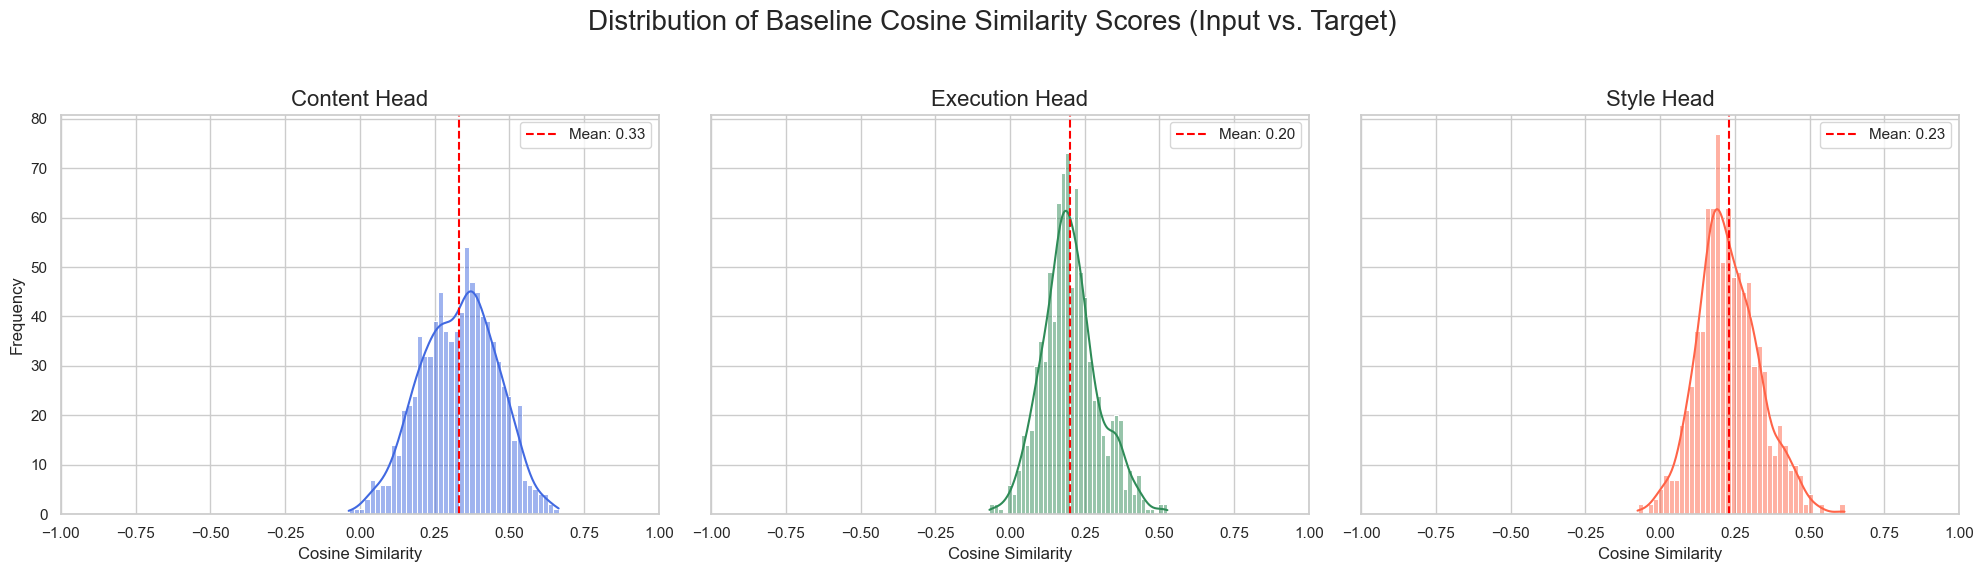

In [19]:
baseline_content_similarities = []
baseline_execution_similarities = []
baseline_stylistic_similarities = []

with torch.no_grad():

    for context_b, content_b, exec_b, style_b in tqdm(test_loader, desc="Calculating Baseline Similarities"):

        context_b, content_b, exec_b, style_b = context_b.to(device), content_b.to(device), exec_b.to(device), style_b.to(device)

        baseline_content_sim = F.cosine_similarity(context_b, content_b, dim = 1)
        baseline_exec_sim = F.cosine_similarity(context_b, exec_b, dim=1)
        baseline_style_sim = F.cosine_similarity(context_b, style_b, dim = 1)

        baseline_content_similarities.extend(baseline_content_sim.cpu().numpy())
        baseline_execution_similarities.extend(baseline_exec_sim.cpu().numpy())
        baseline_stylistic_similarities.extend(baseline_style_sim.cpu().numpy())

print("\n--- Baseline Performance on Test Set (Input vs. Target) ---")
print(f"Content   | Mean Cosine Similarity: {np.mean(baseline_content_similarities):.4f} | Std: {np.std(baseline_content_similarities):.4f}")
print(f"Execution | Mean Cosine Similarity: {np.mean(baseline_execution_similarities):.4f} | Std: {np.std(baseline_execution_similarities):.4f}")
print(f"Style     | Mean Cosine Similarity: {np.mean(baseline_stylistic_similarities):.4f} | Std: {np.std(baseline_stylistic_similarities):.4f}")

sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
fig.suptitle('Distribution of Baseline Cosine Similarity Scores (Input vs. Target)', fontsize=20)


sns.histplot(ax=axes[0], data=baseline_content_similarities, kde=True, bins=40, color='royalblue')
axes[0].set_title('Content Head', fontsize=16)
axes[0].set_xlabel('Cosine Similarity', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_xlim(-1, 1)
axes[0].axvline(np.mean(baseline_content_similarities), color='red', linestyle='--', label=f'Mean: {np.mean(baseline_content_similarities):.2f}')
axes[0].legend()

sns.histplot(ax=axes[1], data=baseline_execution_similarities, kde=True, bins=40, color='seagreen')
axes[1].set_title('Execution Head', fontsize=16)
axes[1].set_xlabel('Cosine Similarity', fontsize=12)
axes[1].set_xlim(-1, 1)
axes[1].axvline(np.mean(baseline_execution_similarities), color='red', linestyle='--', label=f'Mean: {np.mean(baseline_execution_similarities):.2f}')
axes[1].legend()

sns.histplot(ax=axes[2], data=baseline_stylistic_similarities, kde=True, bins=40, color='tomato')
axes[2].set_title('Style Head', fontsize=16)
axes[2].set_xlabel('Cosine Similarity', fontsize=12)
axes[2].set_xlim(-1, 1)
axes[2].axvline(np.mean(baseline_stylistic_similarities), color='red', linestyle='--', label=f'Mean: {np.mean(baseline_stylistic_similarities):.2f}')
axes[2].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()